# Data loading

In [1]:
# from zipfile import ZipFile
# train = './train.zip'
# 
# with ZipFile(train, 'r') as zip:
#   zip.extractall()
#   print('Done')

In [2]:
# from zipfile import ZipFile
# test = './test.zip'
# 
# with ZipFile(test, 'r') as zip:
#   zip.extractall()
#   print('Done')

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import os
import torch.nn.functional as F
import torchvision
import math
import matplotlib.pyplot as plt

# Data preprossing

In [2]:
# Data preprocessing
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [3]:
train_dir = './dataset_slova/train'
test_dir = './dataset_slova/test'
print("done")

done


In [4]:
# Create datasets
train_dataset = ImageFolder(train_dir, transform=transform)
test_dataset = ImageFolder(test_dir, transform=transform)

# Training

In [5]:
# Hyperparameters
batch_size = 16
learning_rate = 0.001

image_width = 475
image_height = 100
# Convolutional layer parameters
kernel_size = 3
stride = 1
padding = 1
channels = 32

# Calculate output size after convolutional layer
conv_output_width = math.floor((image_width - kernel_size + 2 * padding) / stride) + 1
conv_output_height = math.floor((image_height - kernel_size + 2 * padding) / stride) + 1

# Calculate output size after max pooling layer
pool_output_width = math.floor(conv_output_width / 2)
pool_output_height = math.floor(conv_output_height / 2)
print(pool_output_width, pool_output_height)

237 50


In [6]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(pool_output_width * pool_output_height * channels, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, pool_output_width * pool_output_height * channels)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
model = CNN()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
def train(model, train_loader, optimizer, criterion):
    train_loss = 0

    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        #print(outputs.shape)
        outputs = torch.squeeze(outputs)
        #print(outputs.shape)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*inputs.size(0)

    return train_loss

def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            #print(outputs.shape)
            outputs = torch.squeeze(outputs)
            #print(outputs.shape)
            predicted = (outputs > 0).int()  # Convert logits to binary predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'total: {total}, correct: {correct}')
    return accuracy


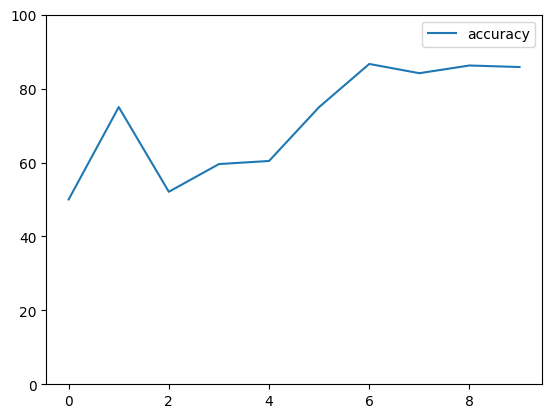

In [11]:
num_epochs = 10
losses = []
accuracies = []
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion)
    accuracy = evaluate(model, test_loader)
    losses.append(train_loss)
    accuracies.append(accuracy*100)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Accuracy: {accuracy*100:.2f}%")
torch.save(model.state_dict(), 'binary_classifier_cnn_words.pth')
# plot loss and accuracy to one graph
# plt.plot(losses, label='loss')
plt.gca().set_ylim(bottom=0, top=100)
plt.plot(accuracies, label='accuracy')
plt.legend()
plt.savefig('100_loss_accuracy.png')
plt.show()

# Save the trained model
# torch.save(model.state_dict(), 'binary_classifier_cnn.pth')

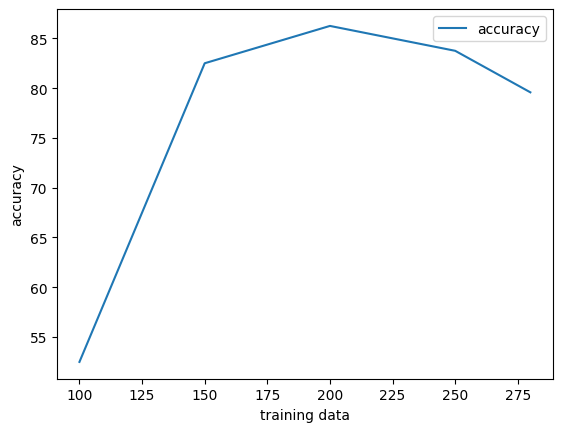

In [6]:
acc = [52.50, 82.50, 86.25, 83.75, 79.58]
data = [100, 150, 200, 250, 280]
plt.plot(data, acc, label='accuracy')
plt.xlabel('training data')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('acc.png')
plt.show()

# Live demo

In [28]:
import torch
from torchvision import transforms
from PIL import Image

# Assume you have a function read_image that returns a PIL Image
def read_image(path):
    return Image.open(path)
# load model
model = CNN()
model.load_state_dict(torch.load('binary_classifier_cnn_words.pth'))

# load our and foreign image:
our_image = read_image('./demo/our1.png')
foreign_image = read_image('./demo/foreign1.png')

# convert to tensor
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# transform images
our_image = transform(our_image)
foreign_image = transform(foreign_image)

# evaluate images
our_image = our_image.unsqueeze(0)
foreign_image = foreign_image.unsqueeze(0)
our_output = model(our_image)
foreign_output = model(foreign_image)

# evaluate:
our_output = torch.squeeze(our_output)
foreign_output = torch.squeeze(foreign_output)
our_output = (our_output > 0).int()
foreign_output = (foreign_output > 0).int()


# print results
print(f'Our image: {our_output}')
print(f'Foreign image: {foreign_output}')


Our image: 0
Foreign image: 1
